# Reflection Agent - Researcher and Self Critique Agent
### Web Research with Iterative self improvement

### Objectives:
* Build a web research agent
* Implement Critique agent for quality control
* Use reflection loop with max iterations

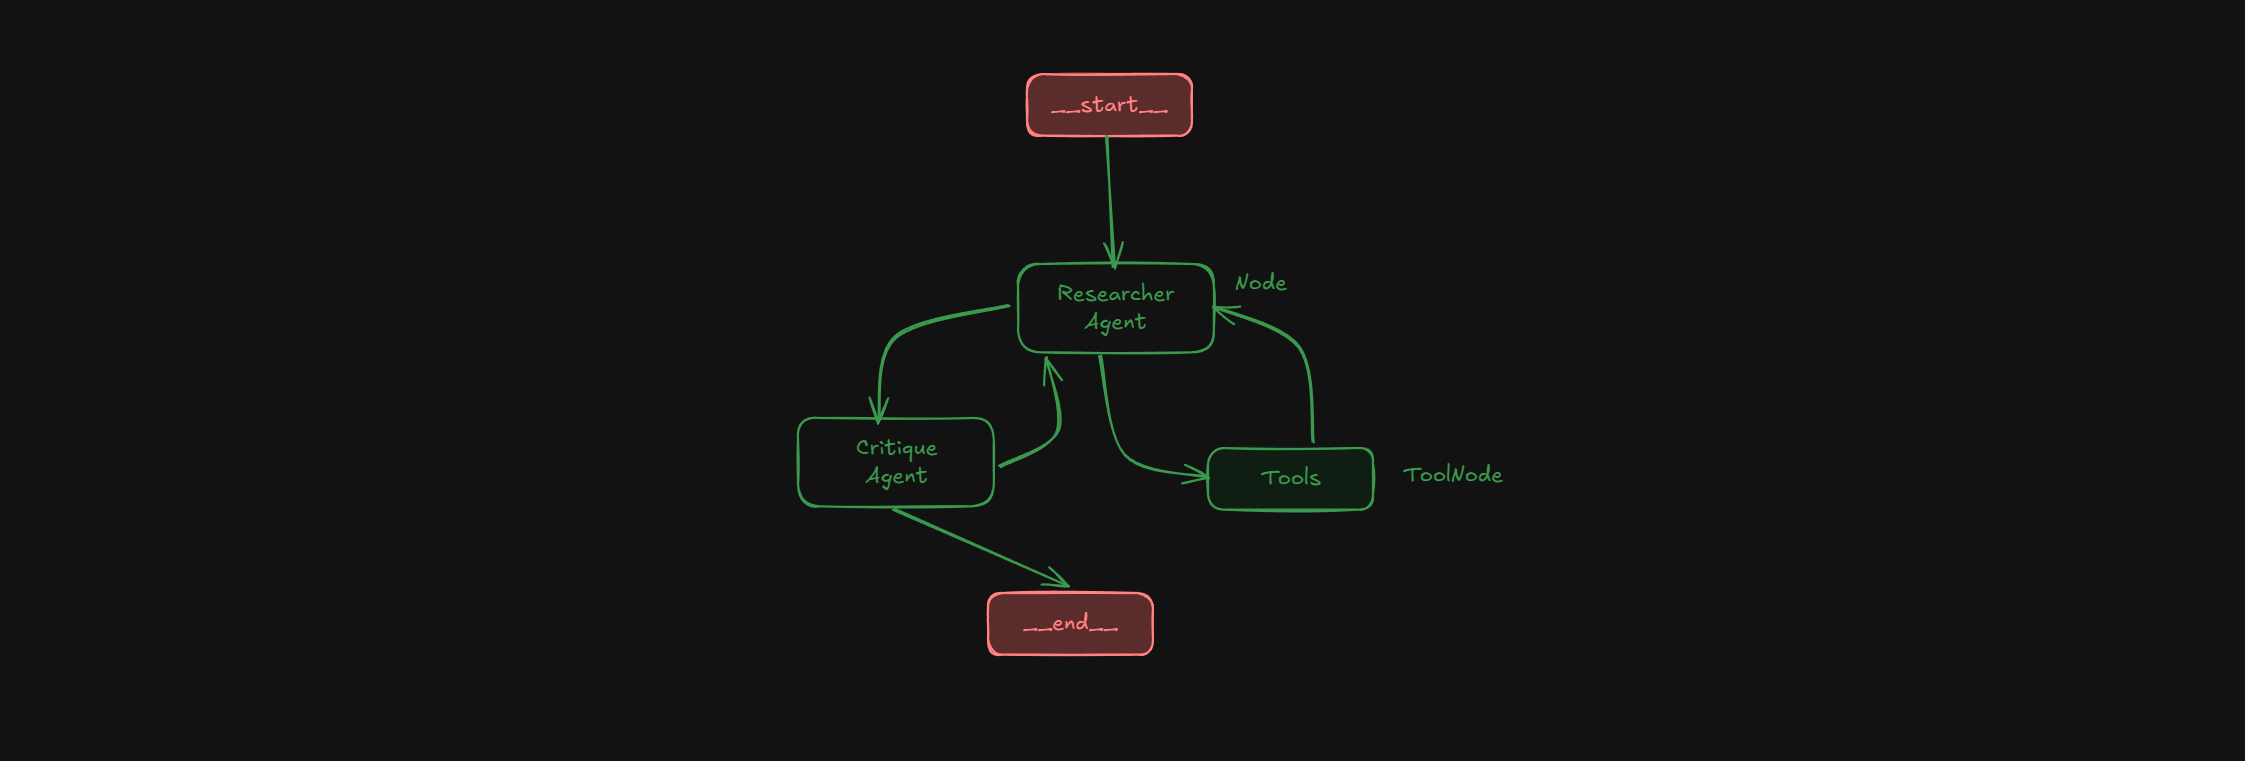

### Imports

In [1]:
# 1. Imports
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict, List, Annotated
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import os

load_dotenv()

True

### LLM Configuration

In [2]:
# 2. Config and setup
BASE_URL = "https://api.groq.com/openai/v1"
MODEL_NAME = "openai/gpt-oss-20b"
API_KEY = os.getenv("GROQ_API_KEY")

def llm():
    return ChatOpenAI(
        model_name=MODEL_NAME,
        base_url=BASE_URL,
        api_key=API_KEY,
        temperature=0.7
    )

groq_llm = llm()

### Web Search Tool

In [3]:
# 3. Web Search Tool
from ddgs import DDGS

@tool
def web_search(query: str, num_results: int = 3) -> str:
    """
    Use this tool whenever you need to access realtime or latest information.
    Search the web using DuckDuckGo.

    Args:
        query: Search query string.
        num_results: Number of results to return (default: 5)
    
    Returns:
        Formatted search results with titles, descriptions and URLs
    """

    results = DDGS().text(query=query, max_results=num_results, region='us-en')

    if not results:
        return f"No results found for the query: '{query}'"
    
    formatted_results = [f"Search Results for search query: '{query}'"]
    for i, result in enumerate(results, 1):
        title = result.get("title", "No title")
        href = result.get("href", "")
        body = result.get("body", "No description available")

        text = f"{i}. **{title}**\n**{body}**\n**{href}**"

        formatted_results.append(text)

    return "\n\n".join(formatted_results)


In [4]:
response = web_search.invoke({"query": "Quantum Physics", "num_results": 3})
print(response)

Search Results for search query: 'Quantum Physics'

1. **Quantum Physics**
**Quantum mechanics is the fundamental physical theory that describes the behavior of matter and of light; its unusual characteristics typically occur at and below the scale of atoms. It is the foundation of all quantum physics, which includes quantum chemistry, quantum biology, quantum field theory, quantum technology, and quantum information science.Quantum mechanics can describe many systems that classical physics cannot. Classical physics can describe many aspects of nature at an ordinary (macroscopic and (optical) microscopic) scale, but is not sufficient for describing them at very small submicroscopic (atomic and subatomic) scales. Classical mechanics can be derived from quantum mechanics as an approximation that is valid at ordinary scales.Quantum systems have bound states that are quantized to discrete values of energy, momentum, angular momentum, and other quantities, in contrast to classical systems w

### Agent State

In [5]:
# 4. Defining State
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    research: str
    critique: str
    iterations: int

### Research Node

In [6]:
# Nodes
def research_agent(state: AgentState):
    llm_with_tools = groq_llm.bind_tools([web_search])

    critique = state.get("critique", "")
    iteration = state.get("iteration", 0)

    feedback_prompt = ""
    if critique:
        feedback_prompt = f"""
                Previous Critique: {critique}
                Address the missing points with new search queries.
                """

    system_prompt = SystemMessage(f"""
        You are a research agent with web search capabilities.
        {feedback_prompt}
        INSTRUCTIONS:
        1. **MUST use web_search tool** first to gather information
        2. Provide comprehensive research based on search results

        Always call **web_search** before responding.
    """)

    messages = [system_prompt] + state['messages']

    response = llm_with_tools.invoke(messages)

    if hasattr(response, 'tool_calls') and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[RESEARCHER] called Tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
    else:
        print(f"[RESEARCHER] Responding with iteration number: {iteration + 1}")
    
    return {"messages": [response]}

### Critique Agent

In [7]:
def critique_agent(state: AgentState):
    messages = state['messages']
    iterations = state['iterations']

    research_content = messages[-1].content

    system_prompt = SystemMessage("""
        You are a critique agent. Evaluate if research is good enough.
        
        Check:
        1. Does it answer the main question?
        2. Is there reasonable detail?
        
        Response Format:
        DECISION: APPROVE or REVISE
        
        Be lenient. APPROVE if research is decent enough.
        Only REVISE if critical information is completely missing.
    """)

    critique_prompt = HumanMessage(f"""
        Evaluate this research:
        {research_content}
    """)

    messages = [system_prompt, critique_prompt] 
    response = llm.invoke(messages)

    print(f"[CRITIQUE] Iteration {iterations + 1}")

    return {
        "critique": response.content,
        "research": research_content,
        "iteration": iterations + 1
    }

### Routing Logic

In [8]:
# Tool Should Continue
def should_continue(state: AgentState):
    last_message = state['messages'][-1]

    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tool_node"
    else:
        return "critique"

In [9]:
# Critique Routing
MAX_ITERATIONS = 10
def check_approval(state: AgentState):
    critique = state.get('critique', '')
    iterations = state.get('iterations', 0)

    if iterations >= MAX_ITERATIONS:
        print(f"[SYSTEM] Max iterations {MAX_ITERATIONS} reached. Stopping")
        return END
    
    if "APPROVE" in critique.upper():
        print(f"[SYSTEM] Research approved after ({iterations} iterations)")
        return END
    else:
        print(f"[SYSTEM] Imporvement required. Continuing iteration {iterations + 1}")

### Building Graph

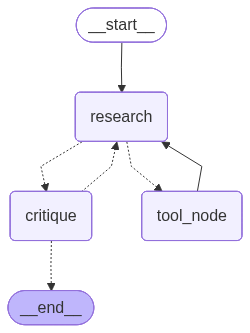

In [10]:
def graph_builder():
    builder = StateGraph(AgentState)

    # Nodes
    builder.add_node("research", research_agent)
    builder.add_node("critique", critique_agent)
    builder.add_node("tool_node", ToolNode([web_search]))

    # Adding edges
    builder.add_edge(START, "research")
    builder.add_conditional_edges("research", should_continue, ["tool_node", "critique"])
    builder.add_edge("tool_node", "research")
    builder.add_conditional_edges("critique", check_approval, ["research", END])

    graph = builder.compile()
    return graph

agent = graph_builder()
agent

### Testing of the agent

In [ ]:
query = "What are the Latest developments in Langgraph"
result = agent.invoke({"messages": [HumanMessage(content=query)], "iterations": 0})